# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1044]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [1049]:
# Define a function to load data and aggregate them

def combine_dataset(flist):
    combined_df = []

    for f in flist:
        df = pd.read_csv(f)
        combined_df.append(df)

    final_df = pd.concat(combined_df, ignore_index=True)
    return final_df

In [1051]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
raw_data_files = ['RNN_Stocks_Data/AMZN_stocks_data.csv', 'RNN_Stocks_Data/GOOGL_stocks_data.csv', 'RNN_Stocks_Data/IBM_stocks_data.csv', 'RNN_Stocks_Data/MSFT_stocks_data.csv']
df = combine_dataset(raw_data_files)

In [1053]:
# View specifics of the data
df.tail()

,Date,Open,High,Low,Close,Volume,Name
12072,2017-12-22,85.40,85.63,84.92,85.51,14145841,MSFT
12073,2017-12-26,85.31,85.53,85.03,85.40,9891237,MSFT
12074,2017-12-27,85.65,85.98,85.22,85.71,14678025,MSFT
12075,2017-12-28,85.90,85.93,85.55,85.72,10594344,MSFT
12076,2017-12-29,85.63,86.05,85.50,85.54,18717406,MSFT


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [1056]:
# Handle Missing Values
df.isnull().sum()

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

In [1058]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB


In [1060]:
df = df.dropna()
print(df.isnull().sum())
df.info()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 12076 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12076 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12076 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12076 non-null  float64
 5   Volume  12076 non-null  int64  
 6   Name    12076 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 754.8+ KB


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

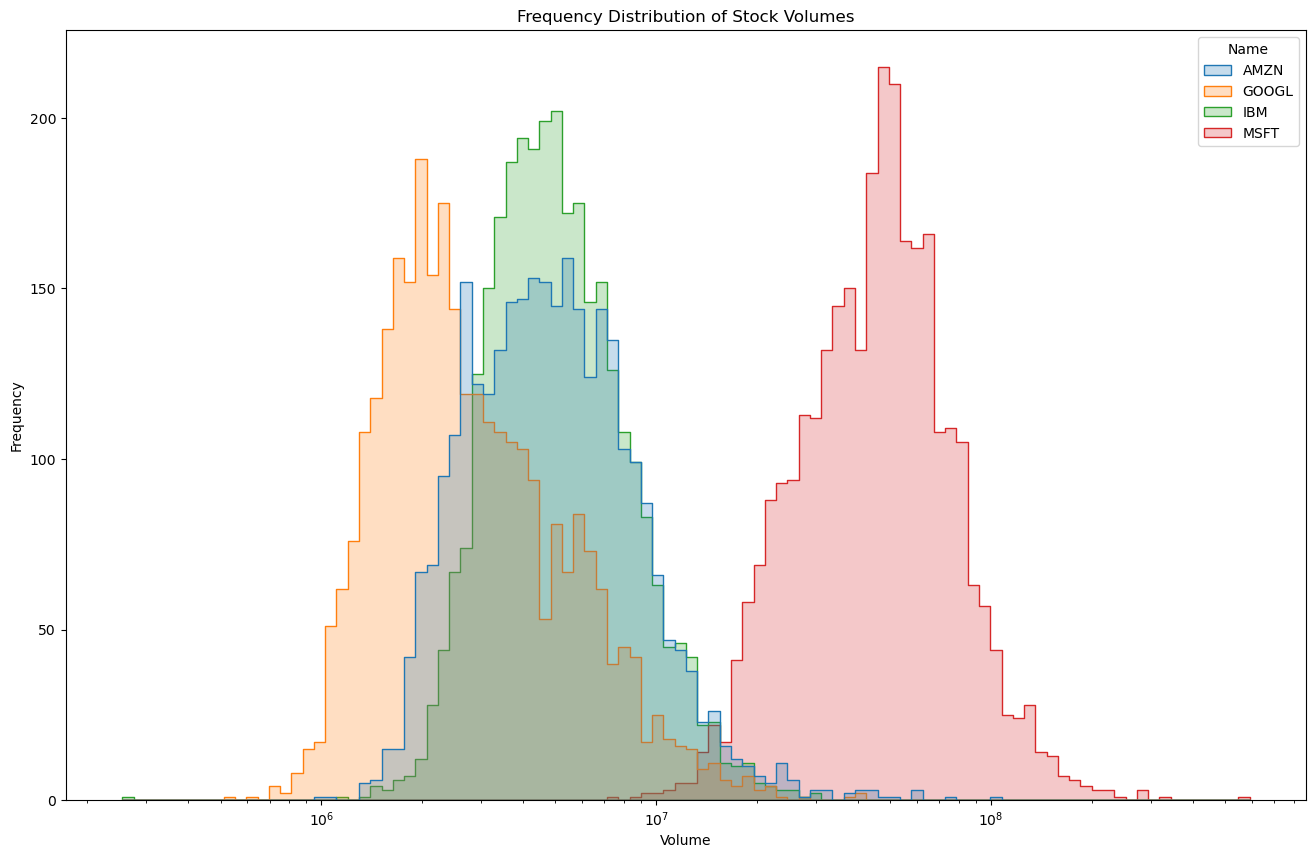

In [1064]:
# Frequency distribution of volumes
plt.figure(figsize=(16, 10))
sns.histplot(data=df, x='Volume', hue='Name', bins=100, element='step', log_scale=True)
#sns.displot(data=df, x='Volume', col='Name', bins=1000, log_scale=True, height=4, aspect=1.2)
plt.title('Frequency Distribution of Stock Volumes')
plt.xlabel('Volume')
plt.ylabel('Frequency')
#plt.legend(title='Stock Name')
plt.show()

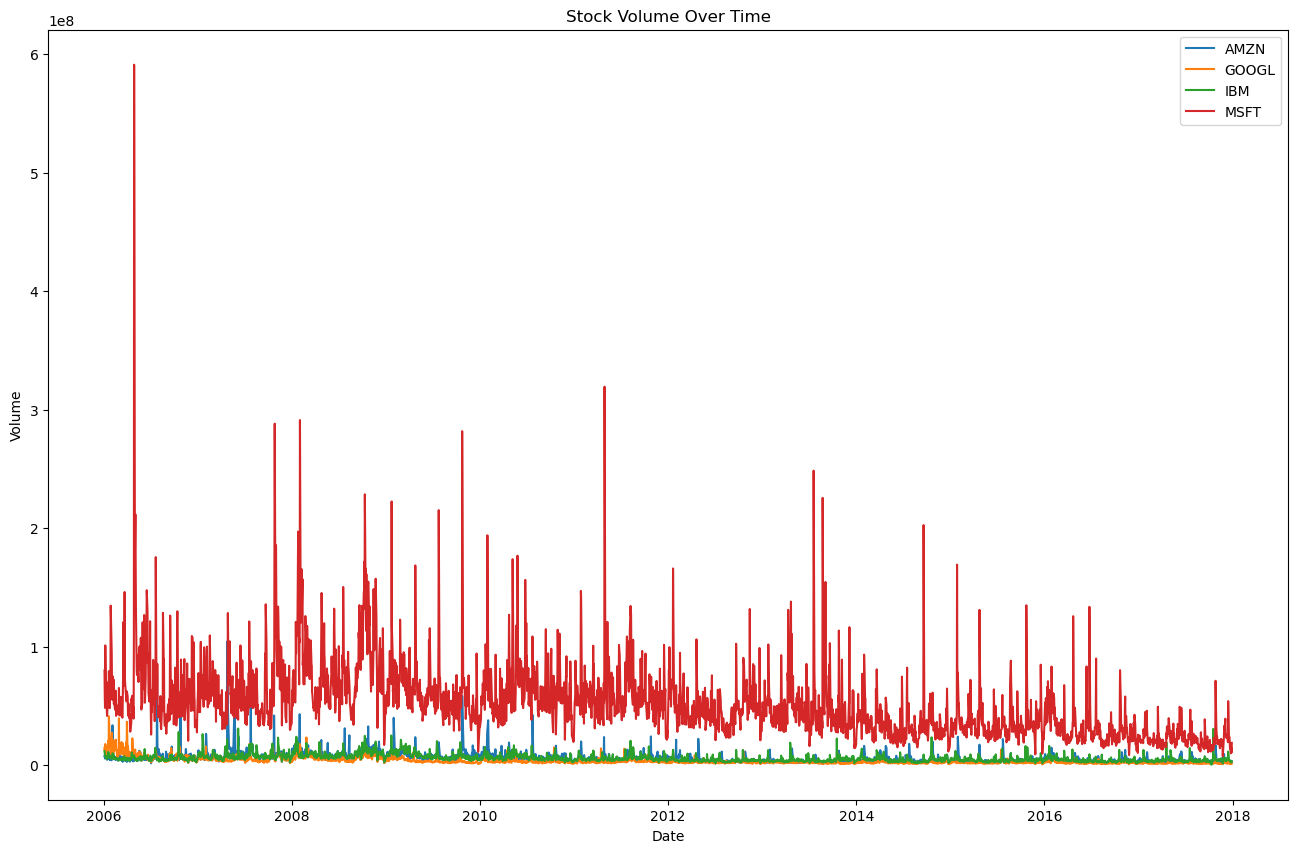

In [1066]:
# Stock volume variation over time
cname_list = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

plt.figure(figsize=(16, 10))
for name in cname_list:
    sdf = df[df['Name'] == name]
    plt.plot(pd.to_datetime(sdf['Date']), sdf['Volume'], label=name)

plt.title('Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
#plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

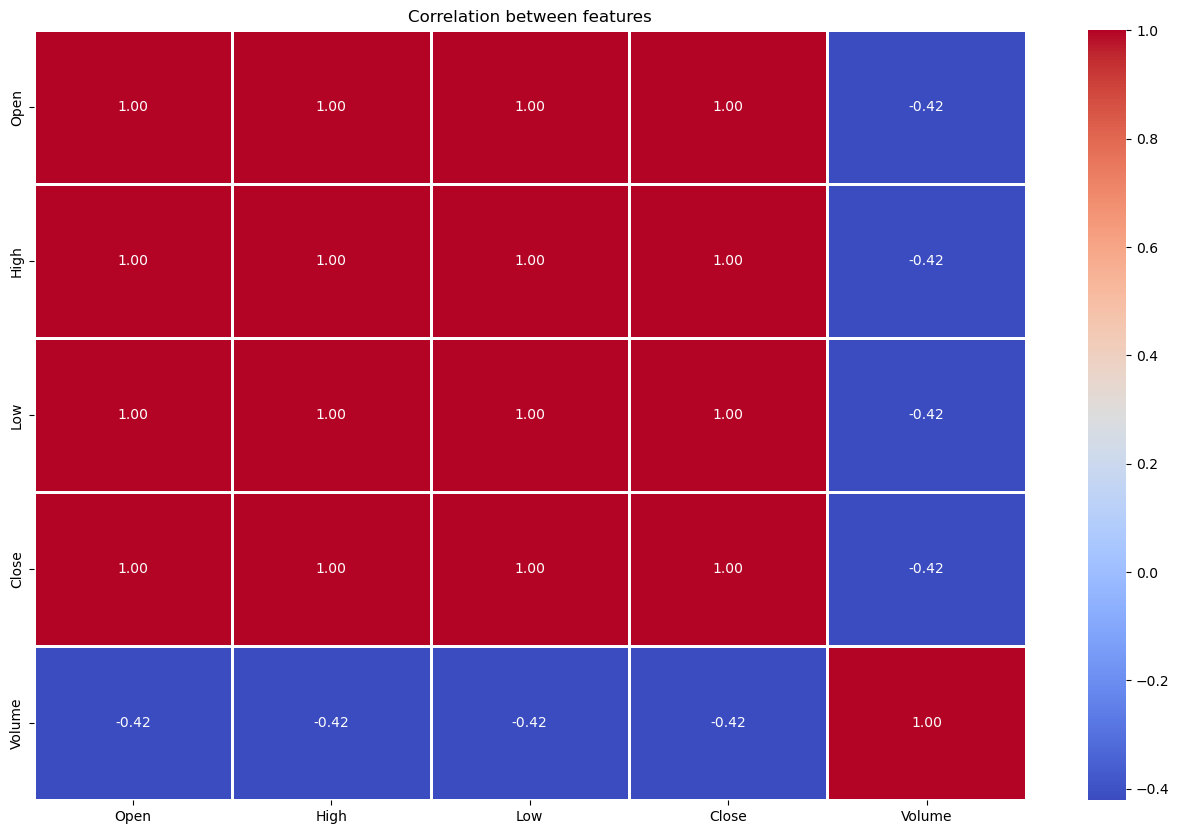

In [1069]:
# Analyse correlations
correlation = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(16, 10))

# Heatmap to visualize the correlation
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.9)

plt.title('Correlation between features')
plt.show()

In [1071]:
correlation

,Open,High,Low,Close,Volume
Open,1.000000,0.999945,0.999919,0.999873,-0.420741
High,0.999945,1.000000,0.999907,0.999935,-0.421103
Low,0.999919,0.999907,1.000000,0.999945,-0.420673
Close,0.999873,0.999935,0.999945,1.000000,-0.420895
Volume,-0.420741,-0.421103,-0.420673,-0.420895,1.000000


### Stock Price are strongly correlated each other with price 'Open', 'High', 'Low', 'Close' correlation coefficent are 0.99 
### Stock price  and volume are -ve correlated -0.42, This indicats high volumes tend with lower stock prices or low stock volume related with the high 'Open', 'High', 'Low', 'Close' price

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [1079]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_window_df(sdf, window_size, step_size, target_names=[]):
    X,y = [], []
    
    # sort by date to maintain time order
    sdf = sdf.sort_values(by='Date').reset_index(drop=True)
    
    for i in range(0, len(sdf) - window_size, step_size):
        window_df = sdf.iloc[i:i + window_size]
        index = i + window_size

        # check if index is valid
        if index < len(df): 
            next_row = df.iloc[index]

            # Check the next_row stock is valid value belongs to  target_names list
            if next_row['Name'] in target_names:
                X.append(window_df)
                y.append(next_row['Close'])

    return X, y

In [1081]:
# Testing of "create_window_df" function 
X_list, y_list = create_window_df(df, window_size=3, step_size=1, target_names=['AMZN', 'GOOGL', 'IBM', 'MSFT'])
X_list[0:3]

[         Date    Open    High     Low   Close    Volume   Name
 0  2006-01-03   47.47   47.85   46.25   47.58   7582127   AMZN
 1  2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
 2  2006-01-03   26.25   27.00   26.10   26.84  79974418   MSFT,
          Date    Open    High     Low   Close    Volume   Name
 1  2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
 2  2006-01-03   26.25   27.00   26.10   26.84  79974418   MSFT
 3  2006-01-03   82.45   82.55   80.81   82.06  11715200    IBM,
          Date   Open   High    Low  Close    Volume  Name
 2  2006-01-03  26.25  27.00  26.10  26.84  79974418  MSFT
 3  2006-01-03  82.45  82.55  80.81  82.06  11715200   IBM
 4  2006-01-04  26.77  27.08  26.77  26.97  57975661  MSFT]

In [1083]:
y_list[0:3]

[47.87, 47.08, 45.65]

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [1087]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y):
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
#    x_scaler = StandardScaler()
#    y_scaler = StandardScaler()
    
    # Drop non-numeric columns ('Date' and 'Name')
    X_numeric_list = []
    for w in X:
        numeric_window = w.drop(columns=['Date', 'Name'])
        X_numeric_list.append(numeric_window)

    # Partial fit on each window (for X) ---
    for w in X_numeric_list:
        x_scaler.partial_fit(w)

    # Partial fit on y
    y_array = np.array(y).reshape(-1, 1)
    y_scaler.partial_fit(y_array)

    # Transform
    X_scaled = [x_scaler.transform(w) for w in X_numeric_list]
    y_scaled = y_scaler.transform(y_array)

    # Convert list of arrays into a numpy array
    X_scaled_array = np.array(X_scaled)

    return X_scaled_array, y_scaled

In [1089]:
# Testing of scale_windowed_data function
X_scaled, y_scaled = scale_windowed_data(X_list, y_list)
print(X_scaled.shape[0])
X_scaled

12073


array([[[0.02712494, 0.02690789, 0.02667732, 0.02746722, 0.01240279],
        [0.16497714, 0.16900291, 0.16530928, 0.17166379, 0.02180546],
        [0.00928821, 0.00950083, 0.00954705, 0.00990107, 0.1349304 ]],

       [[0.16497714, 0.16900291, 0.16530928, 0.17166379, 0.02180546],
        [0.00928821, 0.00950083, 0.00954705, 0.00990107, 0.1349304 ],
        [0.05652781, 0.05587791, 0.05605808, 0.05667073, 0.01939823]],

       [[0.00928821, 0.00950083, 0.00954705, 0.00990107, 0.1349304 ],
        [0.05652781, 0.05587791, 0.05605808, 0.05667073, 0.01939823],
        [0.0097253 , 0.00956762, 0.01011664, 0.01001118, 0.09769639]],

       ...,

       [[0.88011062, 0.87596323, 0.88287653, 0.8815259 , 0.00125248],
        [0.98665187, 0.98053916, 0.99424457, 0.99175899, 0.00268679],
        [0.87442842, 0.87029446, 0.88229843, 0.87936613, 0.00156744]],

       [[0.98665187, 0.98053916, 0.99424457, 0.99175899, 0.00268679],
        [0.87442842, 0.87029446, 0.88229843, 0.87936613, 0.00156744],

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [1094]:
# Define a function to create input and output data points from the master DataFrame
def main_function( df, target_name,window_size, stride, split_ratio):
    # create windowed data
    X_list, y_list = create_window_df(df, window_size, stride, target_name)
    # scale the windowed data
    X_scaled, y_scaled = scale_windowed_data(X_list, y_list)

    # train test split 
    total_sample=X_scaled.shape[0]
    spoint = int(total_sample * split_ratio)
    
    X_train = X_scaled[:spoint]
    y_train = y_scaled[:spoint]
    X_test = X_scaled[spoint:]
    y_test = y_scaled[spoint:]

    return X_train, y_train, X_test, y_test


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [1099]:
# Checking for patterns in different sequence lengths

def plot_target_over_time(df, stock_name, time_granularity):
    
    # Filter by stock_name
    stock_df = df[df['Name'] == stock_name].copy()

    # updated Date is datetime
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])

    # Sort by date
    stock_df = stock_df.sort_values('Date')

    # Set Date as index
    stock_df.set_index('Date', inplace=True)

    # Resample the Close prices based on time granularity 
    resampled_close = stock_df['Close'].resample(time_granularity).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(resampled_close, marker='o', linestyle='-')
    plt.title(f'{stock_name} Closed Price graph')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True)
    plt.show()

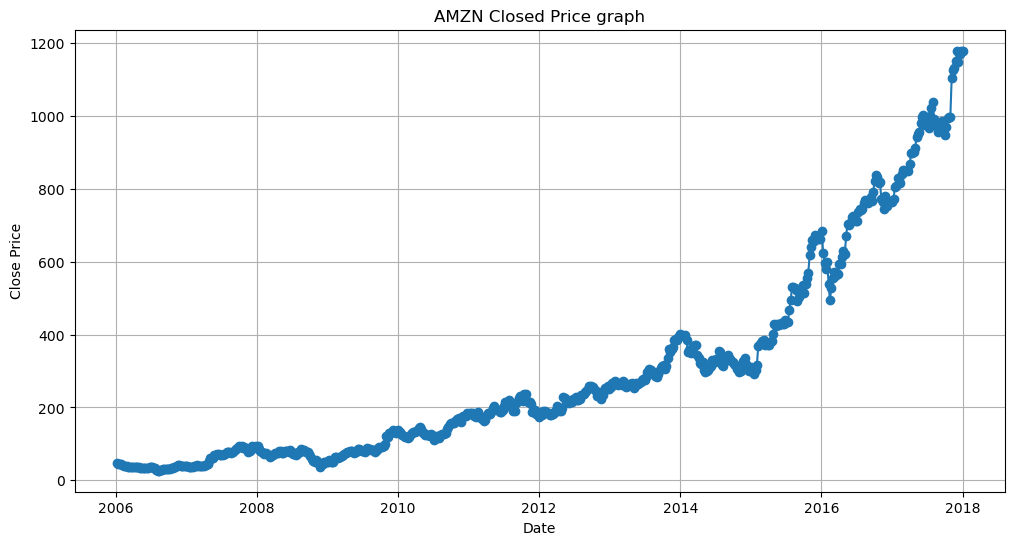

In [1101]:
# Plot AMAN time_granularity Month  
plot_target_over_time(df, 'AMZN', time_granularity='W')

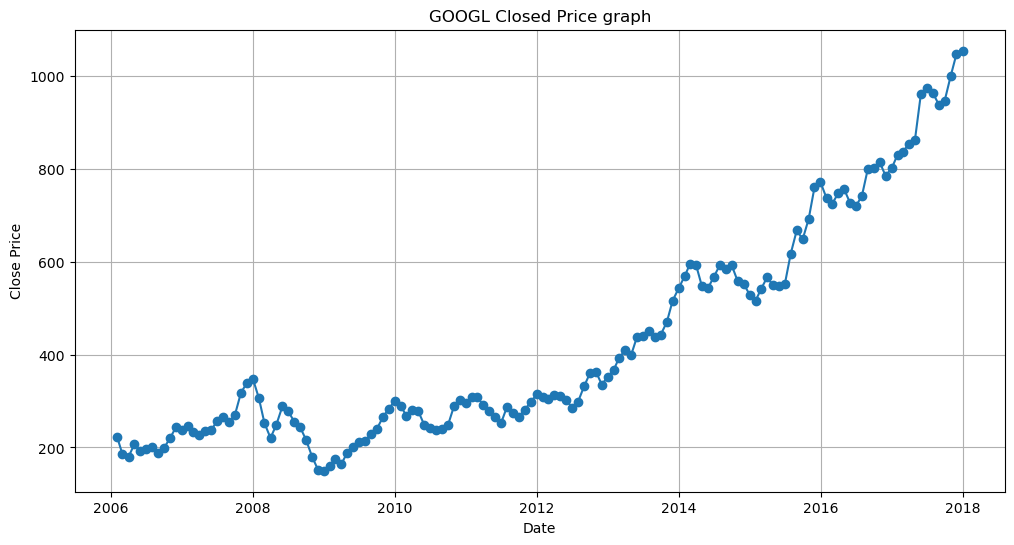

In [1103]:
# Plot GOOGL time_granularity Month  
plot_target_over_time(df, 'GOOGL', time_granularity='M')

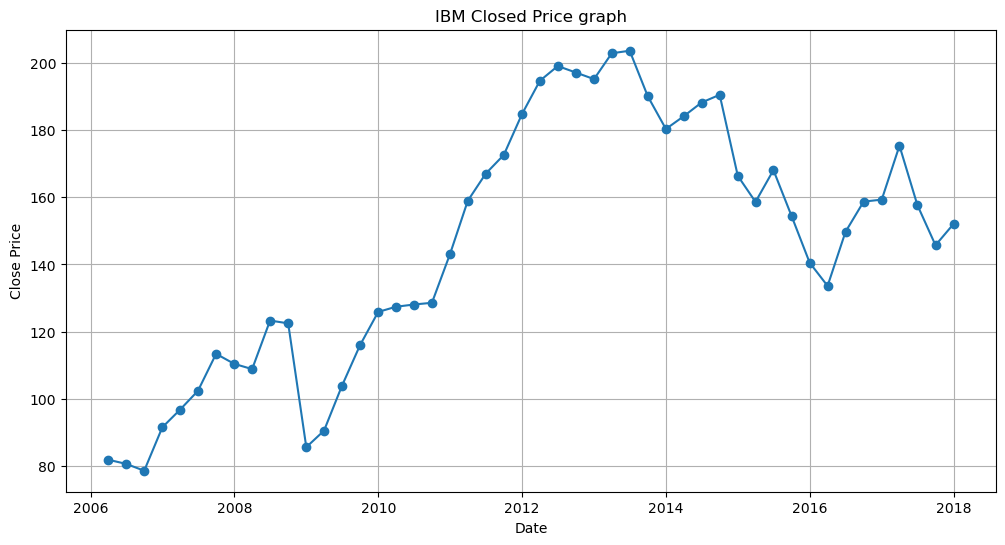

In [1105]:
# Plot IBM time_granularity Month  
plot_target_over_time(df, 'IBM', time_granularity='Q')

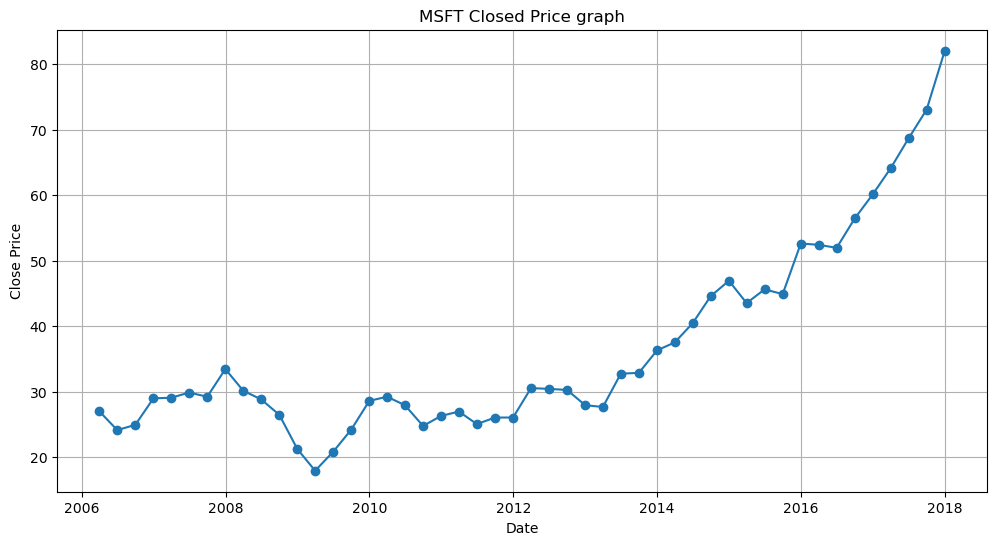

In [1107]:
# Plot MSFT time_granularity Month  
plot_target_over_time(df, 'MSFT', time_granularity='Q')

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [1111]:
# Create data instances from the master data frame using decided window size and window stride
window_size = 30  # Use to set different window size 30-day window
X_train, y_train, X_test, y_test=main_function( df,['AMZN', 'GOOGL', 'IBM', 'MSFT'], window_size, stride=1, split_ratio=0.7)

In [1112]:
# Check the number of data points generated
print(f'train data shape:{X_train.shape} {y_train.shape}\ntest data shape: {X_test.shape} {y_test.shape}')

train data shape:(8432, 30, 5) (8432, 1)
test data shape: (3614, 30, 5) (3614, 1)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [1116]:
# Check if the datasets are compatible inputs to neural networks
print(f'train data shape:{X_train.shape} {y_train.shape}\ntest data shape: {X_test.shape} {y_test.shape}')
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"X_test dtype: {X_test.dtype}")
print(f"y_test dtype: {y_test.dtype}")

train data shape:(8432, 30, 5) (8432, 1)
test data shape: (3614, 30, 5) (3614, 1)
X_train dtype: float64
y_train dtype: float64
X_test dtype: float64
y_test dtype: float64


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [1122]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_rnn_model (input_shape, units, dropout_rate, output_units=1, activation='linear'):
    model = Sequential()
    
    # RNN Layer
   # model.add(SimpleRNN(units=units, input_shape=input_shape, activation, return_sequences=False))
    model.add(SimpleRNN(units=units, input_shape=input_shape, return_sequences=False))
    
    # Dropout
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(output_units, activation=activation))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    return model

In [1124]:
input_shape = (X_train.shape[1], X_train.shape[2])
print(input_shape)
model = create_rnn_model(input_shape=input_shape, units=64, dropout_rate=0.2, output_units=1, activation='linear')
model.summary()

(30, 5)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_16 (SimpleRNN)       │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [1127]:
# Find an optimal configuration of simple RNN



In [1129]:
# Find the best configuration based on evaluation metrics



#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [1132]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

epochs = 30
batch_size = 16

# Train the model
rnn_training=model.fit( X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0549 - val_loss: 0.0099
Epoch 2/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0442 - val_loss: 0.0145
Epoch 3/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0431 - val_loss: 0.0241
Epoch 4/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0414 - val_loss: 0.0166
Epoch 5/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0419 - val_loss: 0.0047
Epoch 6/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0387 - val_loss: 0.0116
Epoch 7/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0380 - val_loss: 0.0100
Epoch 8/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0384 - val_loss: 0.0205
Epoch 9/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0359 - val_loss: 0.0106
Epoch 10/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0351 - val_loss: 0.0083
Epoch 11/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0349 - val_loss: 0.0155
Epoch 12/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Plotting the actual vs predicted values

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


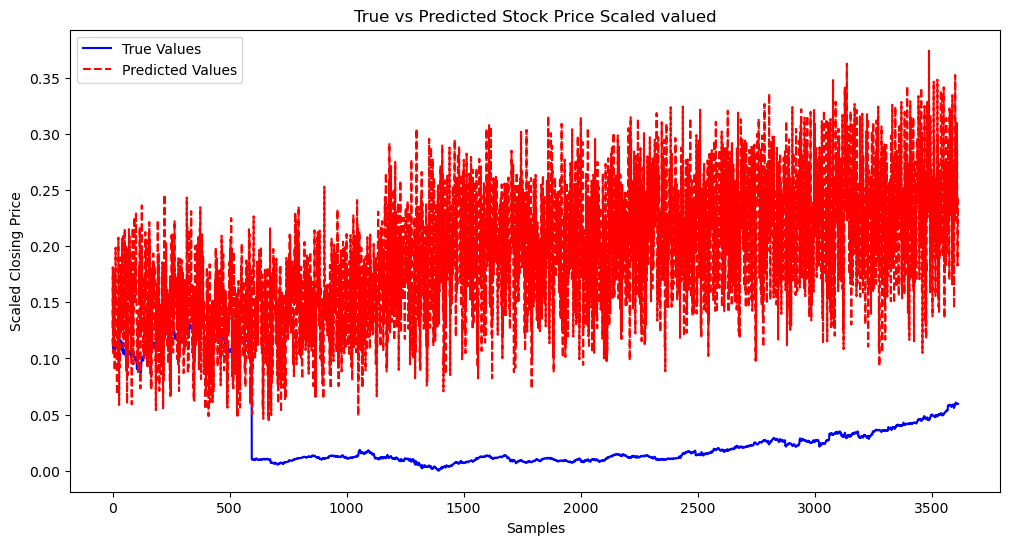

In [1135]:
# Predict on the test data and plot
y_pred = model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red',linestyle='--')
plt.title('True vs Predicted Stock Price Scaled valued')
plt.xlabel('Samples')
plt.ylabel('Scaled Closing Price')
plt.legend()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [1138]:
# Compute the performance of the model on the testing data set
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")


Mean Squared Error (MSE): 0.0291


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [1145]:
# # Define a function to create a model and specify default values for hyperparameters

def create_lstm_model(input_shape):
    model = Sequential()
    
    # Add LSTM Layer
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))  
    model.add(Dropout(0.2))  
    
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))  
    model.add(Dropout(0.2))  
    
    model.add(LSTM(units=64, return_sequences=False))  
    model.add(Dropout(0.2))  
    
    # Output Layer
    model.add(Dense(units=1,activation='linear'))  
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [1147]:
input_shape = X_train.shape[1:] 
model = create_lstm_model(input_shape)

In [1149]:
model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_45 (LSTM)                  │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,033 (328.25 KB)

 Trainable params: 84,033 (328.25 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [1153]:
# Find an optimal configuration



#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [1158]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
lstm_training = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0349 - val_loss: 0.0093
Epoch 2/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0343 - val_loss: 0.0169
Epoch 3/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0333 - val_loss: 0.0179
Epoch 4/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0314 - val_loss: 0.0167
Epoch 5/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0303 - val_loss: 0.0141
Epoch 6/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0289 - val_loss: 0.0136
Epoch 7/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0289 - val_loss: 0.0108
Epoch 8/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0291 - val_loss: 0.0127
Epoch 9/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0271 - val_loss: 0.0107
Epoch 10/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0297 - val_loss: 0.0131
Epoch 11/30
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0280 - val_loss: 0.0089
Epoch 12/30
527/527 ━━━━━━━━━━━━━━━━━━━━

In [1161]:
# Compute the performance of the model on the testing data set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Mean Squared Error (MSE): 0.0120


In [1163]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: -7.1436


Plotting the actual vs predicted values

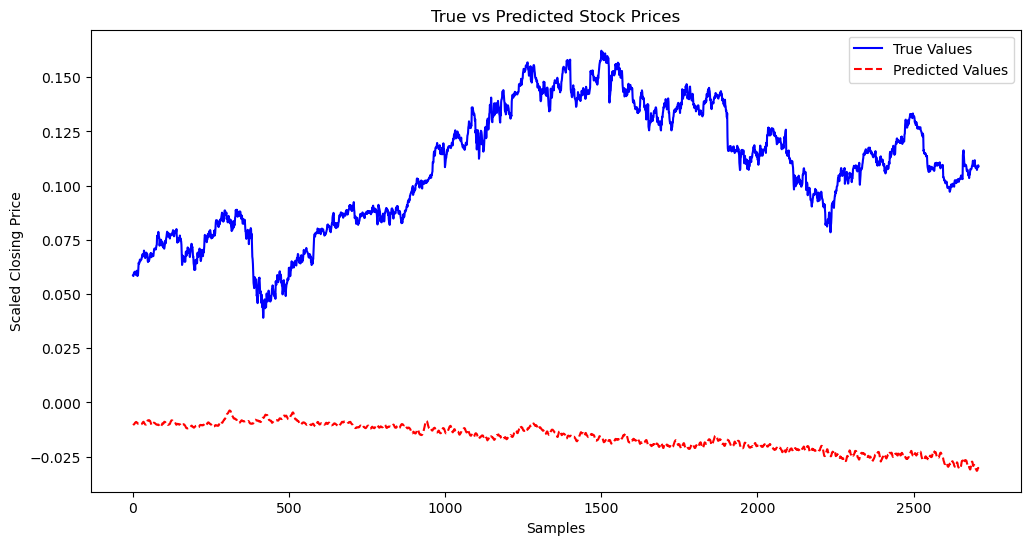

In [1036]:
# Predict on the test data
plt.figure(figsize=(12,6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
plt.title('True vs Predicted Stock Prices')
plt.xlabel('Samples')
plt.ylabel('Scaled Closing Price')
plt.legend()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [1182]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

target_name = "GOOGL"  # specify the specifc target name from ['AMZN', 'GOOGL', 'IBM', 'MSFT']
X_train, y_train, X_test, y_test=main_function( df,target_name, window_size=30, stride=1, split_ratio=0.8)


In [1183]:
# Check the number of data points generated
print(f'train data shape:{X_train.shape} {y_train.shape}\ntest data shape: {X_test.shape} {y_test.shape}')


train data shape:(2415, 30, 5) (2415, 1)
test data shape: (604, 30, 5) (604, 1)


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [1186]:
# Find an optimal configuration of simple RNN



In [1190]:
# Find the best configuration



In [1192]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the
input_shape = (X_train.shape[1], X_train.shape[2])
print(input_shape)
model = create_rnn_model(input_shape=input_shape, units=64, dropout_rate=0.2, output_units=1, activation='linear')
model.summary()

(30, 5)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_17 (SimpleRNN)       │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

In [1194]:
epochs = 30
batch_size = 8

# Train the model
rnn_training=model.fit( X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0834 - val_loss: 0.1372
Epoch 2/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0185 - val_loss: 0.1060
Epoch 3/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138 - val_loss: 0.1337
Epoch 4/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - val_loss: 0.1385
Epoch 5/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088 - val_loss: 0.1146
Epoch 6/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0967
Epoch 7/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - val_loss: 0.0709
Epoch 8/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0940
Epoch 9/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.1220
Epoch 10/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.1035
Epoch 11/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0891
Epoch 12/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [1211]:
# Compute the performance of the model on the testing data set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Mean Squared Error (MSE): 0.0795


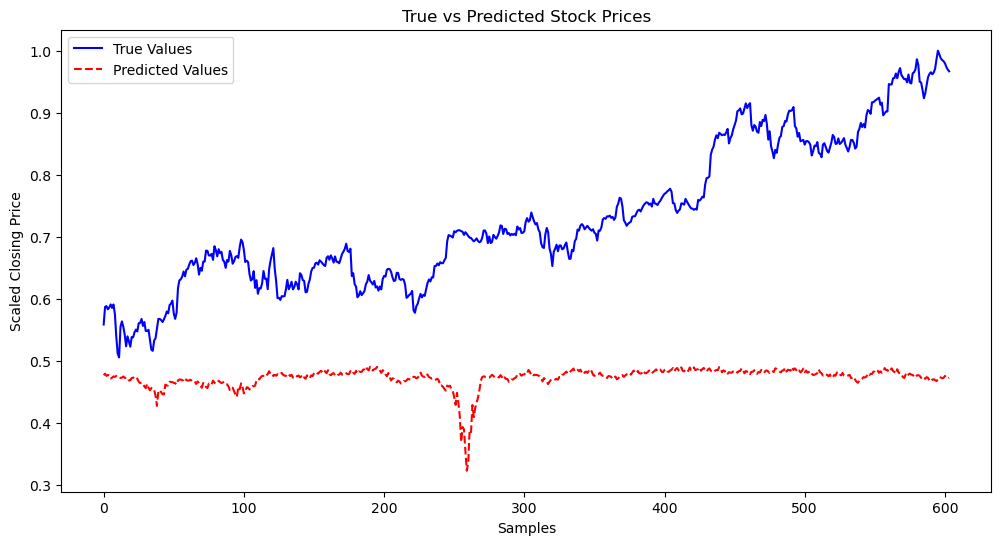

In [1213]:
# Plotting the actual vs predicted values for all targets
plt.figure(figsize=(12,6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
plt.title('True vs Predicted Stock Prices')
plt.xlabel('Samples')
plt.ylabel('Scaled Closing Price')
plt.legend()
plt.show()

#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [1216]:
# Find an optimal configuration of advanced RNN



In [1218]:
# Find the best configuration



In [1220]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model
input_shape = X_train.shape[1:] 
model = create_lstm_model(input_shape)
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,033 (328.25 KB)

 Trainable params: 84,033 (328.25 KB)

 Non-trainable params: 0 (0.00 B)

In [1222]:
lstm_training = model.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0120 - val_loss: 0.1874
Epoch 2/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0074 - val_loss: 0.2367
Epoch 3/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0071 - val_loss: 0.0913
Epoch 4/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0068 - val_loss: 0.0824
Epoch 5/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0050 - val_loss: 0.0824
Epoch 6/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0046 - val_loss: 0.0904
Epoch 7/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0038 - val_loss: 0.0917
Epoch 8/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0038 - val_loss: 0.0952
Epoch 9/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0038 - val_loss: 0.1044
Epoch 10/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0037 - val_loss: 0.0806
Epoch 11/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0036 - val_loss: 0.0928
Epoch 12/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 

In [1226]:
# Compute the performance of the model on the testing data set

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Mean Squared Error (MSE): 0.0770


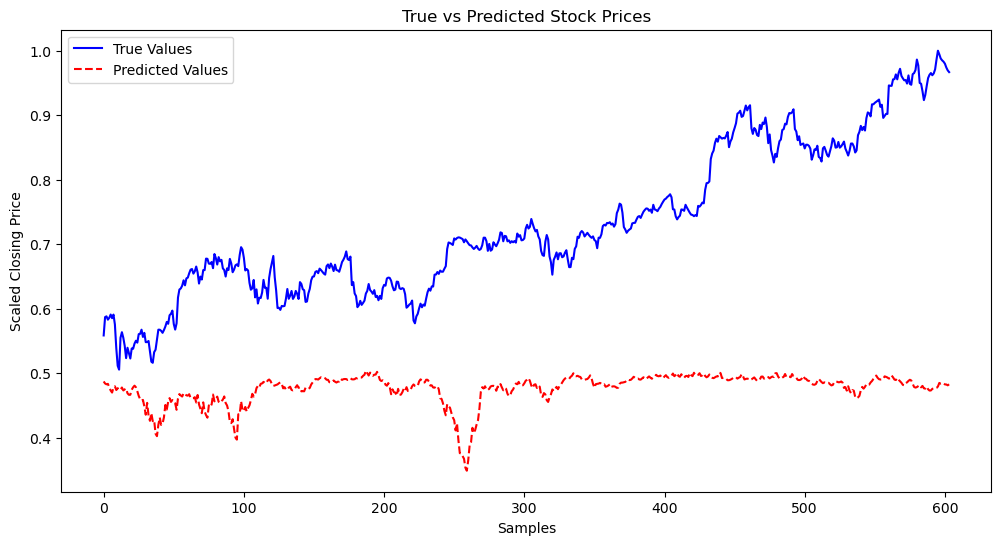

In [1229]:
# Plotting the actual vs predicted values for all targets
plt.figure(figsize=(12,6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
plt.title('True vs Predicted Stock Prices')
plt.xlabel('Samples')
plt.ylabel('Scaled Closing Price')
plt.legend()
plt.show()

## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

-  Stock Price are strongly correlated each other with price 'Open', 'High', 'Low', 'Close' correlation coefficent are 0.99
Stock price and volume are -ve correlated -0.42, This indicats high volumes tend with lower stock prices or low stock volume related with the high 'Open', 'High', 'Low', 'Close

-  Based on frequency distribution MSFT has an average stock trading volume that is much higher compared to AMZN, GOOGL and IBM.
MSFT stock volume is in the range of ~10 million while AMZN, GOOGL, and IBM volumes are in range of ~1 millio
- Test out for different timelines like a 7-day or a 30-day window size
- Model Simple RNN epoch 30 batch size 16 
- Performance of the Simple RNN model with window size 30 days on the testing data set : Mean Squared Error (MSE): 0.0291
- Model LSTM epoch 30 batch size 16 
- Performance of the LSTM RNN model with window size 30 days on the testing data set : Mean Squared Error (MSE):  0.0120
- Prediction for GOOGL stock 'Close' values using Simple RNN model, window size 30 days, model performacne on the testing data set : Mean Squared Error (MSE):0.0795
- Prediction for GOOGL stock 'Close' values using LSTM model, window size 30 days, model performacne on the testing data set : Mean Squared Error (MSE): 0.0770
¶